# House Prices Prediction - Part 1

Ideas to improve the performance:

- Transform 'SalePrice' to [logp1](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html#numpy.log1p) (makes the distribution closer to a normal distribution). After predicting values, the target shall be reverted with [expm1](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html)
- Transform skewed features by means of [box-cox transformation](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)
- Create features from existing ones. For example 'Total Area' = sum of Basement, 1st floor and 2nd floor areas.

References:

- [Kaggle - masumrumi](https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing/comments#$$-{y}-=-mX-+-b-$$)
- [Kaggle - lavanyashukla01](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition?rvi=1)
- [DQ - cablue01](https://github.com/cablue01/Kaggle-House-Prices-Competition/blob/master/Kaggle_House_Prices_Advanced_Regression_Techniques.ipynb)


## Numerical Features Selection

In [78]:
# %load project_dependencies.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns

style.use('default') # reset
#style.use('tableau-colorblind10')
style.use('ggplot')
%matplotlib inline

from scipy import stats

## Exploring the dataset

In [79]:
# Train dataset
df_train = pd.read_csv("train.csv", delimiter=",", index_col='Id')
df_test = pd.read_csv("test.csv", delimiter=",", index_col='Id')
# All together
df = pd.concat((df_train.drop('SalePrice', axis=1), df_test))#.reset_index(drop = True)

In [141]:
df_train

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal  12.247699  
2          0      5    2007        WD         Normal  12.109016  
3          0      9    2008        WD         Normal  12.317171  
4          0      2    2006        WD        Abnorml  11.849405  
5          0     12    2008        WD         Normal  12.429220  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal  12.072547  
1457       0      2    2010        WD         Normal  12.254868  
1458    2500      5    2010        WD         Normal  12.493133  
1459       0      4    2010        WD         Normal  11.864469  
1460       0      6    2008        WD         Normal  11.901590  

[1460 rows x 80 columns]

In [81]:
# Check type and missing values for each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [142]:
df_test

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2918         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2919         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2915         NaN       0       6    2006        WD         Normal  
2916         NaN       0       4    2006        WD        Abnorml  
2917         NaN       0       9    2006        WD        Abnorml  
2918        Shed     700       7    2006        WD         Normal  
2919         NaN       0      11    2006        WD         Normal  

[1459 rows x 79 columns]

In [82]:
df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
3            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
4            Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
5            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2918         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2919         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1            NaN       0       2    2008        WD         Normal  
2            NaN       0       5    2007        WD         Normal  
3            NaN       0       9    2008        WD         Normal  
4            NaN       0       2    2006        WD        Abnorml  
5            NaN       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2915         NaN       0       6    2006        WD         Normal  
2916         NaN       0       4    2006        WD        Abnorml  
2917         NaN       0       9    2006        WD        Abnorml  
2918        Shed     700       7    2006        WD         Normal  
2919         NaN       0      11    2006        WD         Normal  

[2919 rows x 79 columns]

In [83]:
def select_num_features(df):
    return df.select_dtypes(include=['integer', 'float'])

def select_cat_features(df):
    return df.select_dtypes(include=['object'])

In [84]:
# %load print_as_header.py
def print_as_header(s, header_width=30):
    print(header_width * "-")
    print(s)
    print(header_width * "-")

In [85]:
df_num = select_num_features(df)
df_cat = select_cat_features(df)

print_as_header("Dataset Summary")
print('Total Features {} '.format(df.shape[1]))
print('Numerical Features {} '.format(df_num.shape[1]))
print('Categorical Features {} '.format(df_cat.shape[1]))

------------------------------
Dataset Summary
------------------------------
Total Features 79 
Numerical Features 36 
Categorical Features 43 


# Check target distribution

In [86]:
def show_distribution(df, feature, fix_y_scales=True):
    """
    Creates a graphic showin box plot, Quantile-Quantile (QQ) plot and histogram
    """

    ## creating a grid of 4 cols and 2 rows. 
    fig = plt.figure(figsize=(10,10), constrained_layout=True)
    grid = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

    ## Box Plot
    ax1 = fig.add_subplot(grid[0, :])
    ax1.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='h', ax = ax1)
    
    ## histogram
    ax2 = fig.add_subplot(grid[1, :])
    ax2.set_title('Histogram')
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax2, vertical=False, rug=True)

    # QQ_plot
    ax3 = fig.add_subplot(grid[2:, :])
    ax3.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax3)
    sns.despine(left=True, bottom=True)

    if fix_y_scales:
        # Setup axis
        ax1.set_xlim(0,85e4)
        ax2.set_xlim(0,85e4)
        ax3.set_ylim(0,85e4)

    pass

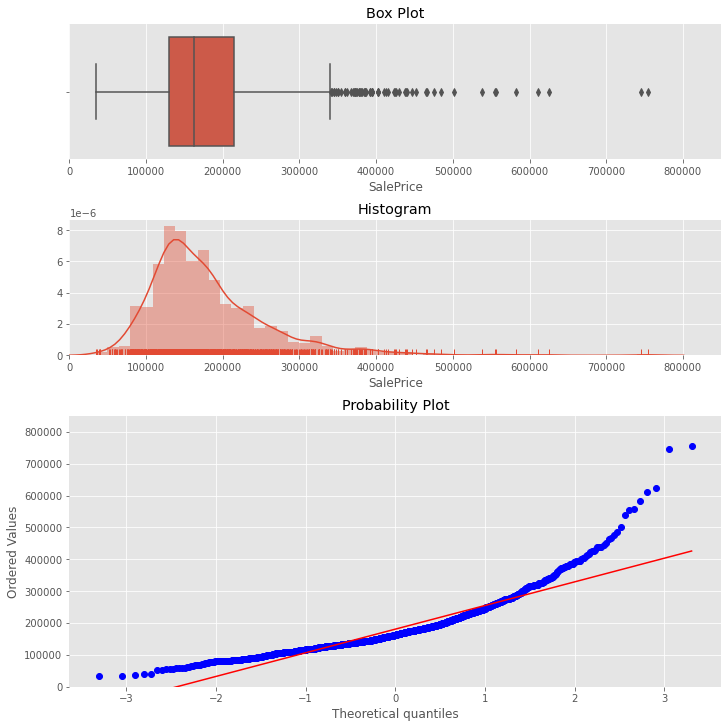

In [87]:
show_distribution(df_train, 'SalePrice')

Some insights:

- The **probability plot** shows that the target has no [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution#:~:text=The%20normal%20distribution%20is%20the,a%20specified%20mean%20and%20variance.).
- The **box plot** shows that there are some [outliers](https://en.wikipedia.org/wiki/Outlier)

Since the distribution is not normal, it would be intereresting to analyze the [skewness](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis).

Pandas offer a [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.skew.html) to evaluate the skewness:

In [88]:
print("Skewness: {:.2f}".format(df_train['SalePrice'].skew()))

Skewness: 1.88


The distribution is positively (or right) skewed, meaning that more houses were sold by less than the average price.

In [89]:
print("Kurtosis: {:.2f}".format(df_train['SalePrice'].kurt()))

Kurtosis: 6.54


The **Kurtosis** value should by near to 3 to match a normal distribution. In this case, we have a higher value. This will help when evaluating the outliers. The less outliers we have, the better kurtosis value.

## Skewness correction for target feature

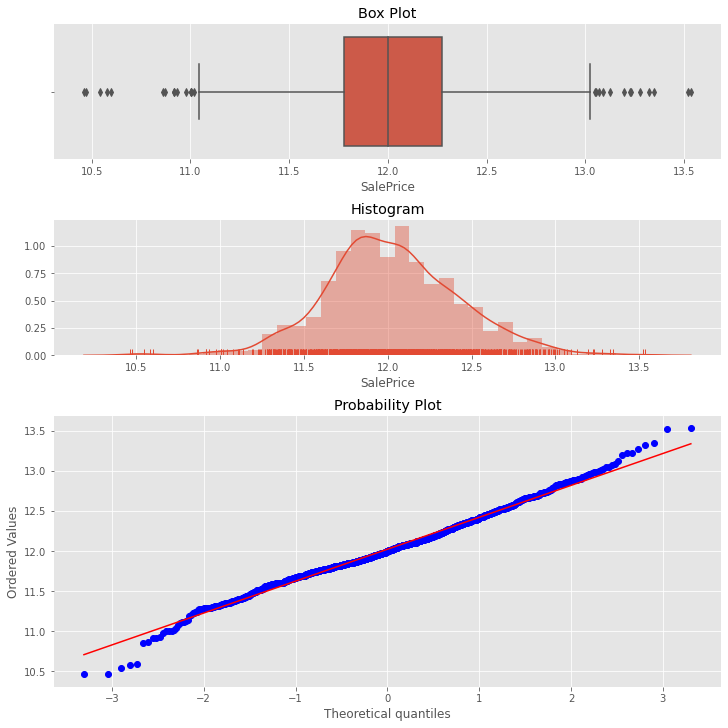

In [90]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
show_distribution(df_train, feature='SalePrice', fix_y_scales=False)

## Feature engineering for Numerical Features

We need to simplify the dataset as much as possible. Fot this reason, I will analyze and determine which numerical columns aren't useful for our target. The following steps are required:

- Missing values: How to deal with them?
- Features correlation and collinearity
- Features scaling

### Managing Missing Values

We will try to avoid deleting any row/column with missing values. For this reason, we have to analyze carefully why there are missing values.

In [91]:
def get_missing_values(df):
    missing = df.isnull().sum()
    non_zero = missing > 0
    return missing[non_zero].sort_values(ascending=False)

In [92]:
def print_missing_values(df):
    print_as_header("Missing values count", 40)
    print(get_missing_values(df))

In [93]:
print_missing_values(df_num)

----------------------------------------
Missing values count
----------------------------------------
LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


What does a missing value mean in these features?

- LotFrontage: Missing input. We will use the Neighborhood mean
- GarageYrBlt: There is no garage (will be analyzed)
- MasVnrArea: There is no Masonry veneer
- BsmtHalfBath: No half bathroom in the basement
- BsmtFullBath: No full bathroom in the basement
- GarageArea: There is no garage (will be analyzed)
- GarageCars: There is no garage (will be analyzed)
- TotalBsmtSF: There is no basement
- BsmtUnfSF: There is no unfinished basement area
- BsmtFinSF2: There is no finished basement (Type 2) area
- BsmtFinSF1: There is no finished basement (Type 1) area

In [94]:
num_feats_w_nan = list(get_missing_values(df_num).index)

In [95]:
# Fill LotFrontage with neigboourhood mean
df_num['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda feature: feature.fillna(feature.mean()))
print("Missing values?")
df_num['LotFrontage'].isna().sum()

Missing values?


C:\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [96]:
# Fill other features with 0
df_num[num_feats_w_nan] = df_num[num_feats_w_nan].fillna(0)

C:\miniconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [97]:
print("Verify missing values:")
print_missing_values(df_num)

Verify missing values:
----------------------------------------
Missing values count
----------------------------------------
Series([], dtype: int64)


## Features skewness

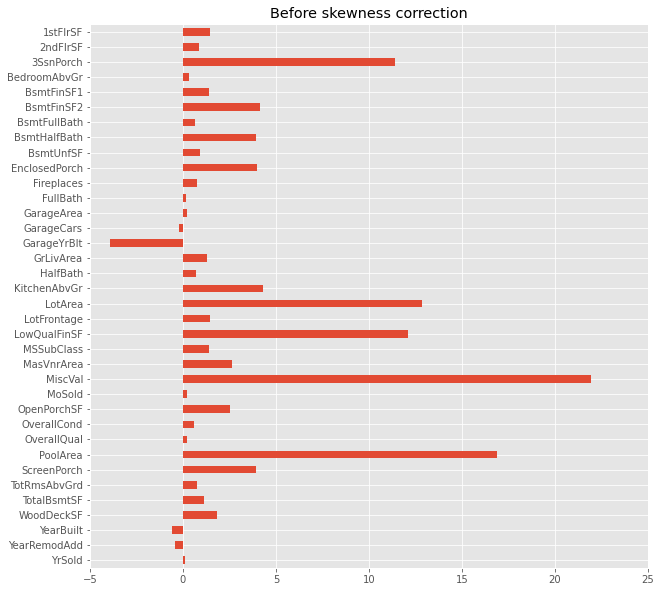

In [98]:
f, ax = plt.subplots(1,1, figsize=(10,10))
df_num.skew().sort_index(ascending=False).plot.barh(ax=ax)
ax.set_xlim(-5,25)
_ = ax.set_title("Before skewness correction")

In [99]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

skewed_feats = df_num.skew().sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
skewed_feats_high = high_skew.index

df_num_deskewed = pd.DataFrame()
for feat in skewed_feats_high:
    df_num[feat] = boxcox1p(df_num[feat], boxcox_normmax(df_num[feat] + 1))

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\miniconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\miniconda3\lib\site-packages\scipy\stats\stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


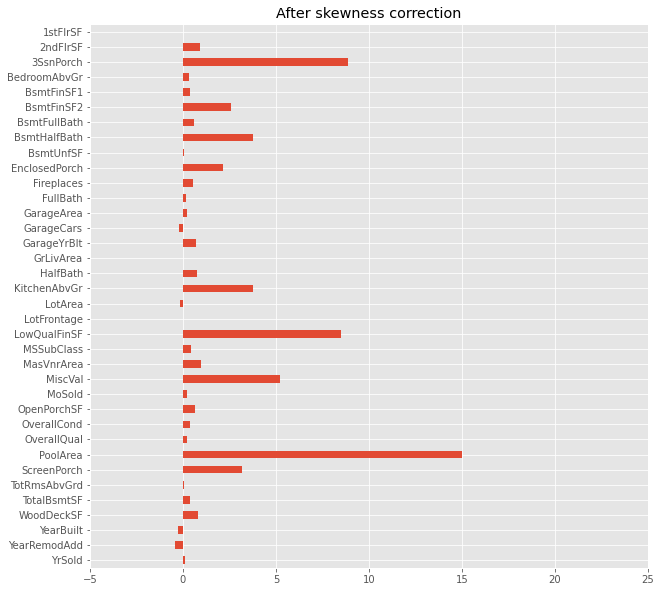

In [100]:
f, ax = plt.subplots(1,1, figsize=(10,10))
df_num.skew().sort_index(ascending=False).plot.barh(ax=ax)
ax.set_xlim(-5,25)
_ = ax.set_title("After skewness correction")

There are feature that still have high skewness. Let's analyze some of them to understand what is happening. 

In [101]:
sel_h_skew_feats = df_num.skew() > 1
h_skew_feats = list(df_num.skew()[sel_h_skew_feats].index)

for f in h_skew_feats:
    print(df_num[f].value_counts().head())

0.000000     2572
8.276546        5
9.488626        5
10.121213       3
10.531702       3
Name: BsmtFinSF2, dtype: int64
0.000000    2879
3.730541       4
4.373606       2
4.738521       2
4.789183       1
Name: LowQualFinSF, dtype: int64
0.000000    2744
0.710810     171
1.143425       4
Name: BsmtHalfBath, dtype: int64
0.750960    2785
1.248553     129
0.000000       3
1.630581       2
Name: KitchenAbvGr, dtype: int64
0.000000     2460
11.247054      22
10.552520      13
12.458294      11
13.974030      10
Name: EnclosedPorch, dtype: int64
0.000000    2882
6.040177       3
6.172888       3
6.271390       2
5.954655       2
Name: 3SsnPorch, dtype: int64
0.000000     2663
21.009511      13
24.444607      11
22.790056      10
19.069704       9
Name: ScreenPorch, dtype: int64
0.000000    2906
5.921859       1
5.130119       1
5.853959       1
5.842099       1
Name: PoolArea, dtype: int64
0.000000    2816
6.314139      18
6.561459      13
6.444550       9
6.764323       8
Name: MiscVal, d

As we see above, these features contains no significant information since most inputs are a constant value. We'drop them.

In [102]:
df_num = df_num.drop(h_skew_feats, axis=1)
print(f'After droping {len(h_skew_feats)} features, the resulting dataset has {df_num.shape[1]} features')

After droping 9 features, the resulting dataset has 27 features


### Features Correlation
We need to see if there is correlation with the sale price for each of the selected columns.
We will consider the feature only if there is a correlation higher than the given threshold.

#### Sale Price Correlation

In [108]:
train_shape = df_train.shape
# slice rows and join with transformed target column
df_num_train = pd.concat([df_num[:train_shape[0]], df_train['SalePrice']], axis=1)
df_num_train

LotFrontage    LotArea  OverallQual     YearBuilt  YearRemodAdd  \
Id                                                                      
1       15.086528  13.424521            7  3.035191e+51          2003   
2       16.999616  13.694528            6  2.444491e+51          1976   
3       15.484624  14.034134            7  2.987217e+51          2002   
4       14.403228  13.683422            7  1.482547e+51          1970   
5       17.480326  14.550143            8  2.963497e+51          2000   
...           ...        ...          ...           ...           ...   
1456    14.679657  13.287740            6  2.939955e+51          2000   
1457    17.598798  14.376784            6  2.484249e+51          1988   
1458    15.220173  13.567456            7  1.838275e+51          2006   
1459    15.484624  13.720310            5  1.979023e+51          1996   
1460    16.382419  13.768026            5  2.236271e+51          1965   

      MasVnrArea  BsmtFinSF1  TotalBsmtSF  1stFlrSF     2ndFlrSF  ...  \
Id                                                                ...   
1      19.378554  117.855863   296.832312  5.318379  1019.540835  ...   
2       0.000000  146.805798   407.302390  5.550627     0.000000  ...   
3      17.721066   91.575284   314.805039  5.362015  1034.306520  ...   
4       0.000000   52.776367   268.234274  5.388291   899.200621  ...   
5      25.323122  112.040325   376.259341  5.493032  1265.167836  ...   
...          ...         ...          ...       ...          ...  ...   
1456    0.000000    0.000000   323.980270  5.383260   823.310159  ...   
1457   15.304342  127.139205   479.523980  5.838137     0.000000  ...   
1458    0.000000   62.223004   378.132762  5.514904  1387.914773  ...   
1459    0.000000   18.884676   358.217353  5.457132     0.000000  ...   
1460    0.000000  131.443563   405.723933  5.547815     0.000000  ...   

      FullBath  HalfBath  TotRmsAbvGrd  Fireplaces   GarageYrBlt  GarageCars  \
Id                                                                             
1            2  1.069352      2.238463    0.000000  8.440343e+56         2.0   
2            2  0.000000      1.978208    0.900816  6.646187e+56         2.0   
3            2  1.069352      1.978208    0.900816  8.293164e+56         2.0   
4            1  0.000000      2.116352    0.900816  8.076926e+56         3.0   
5            2  1.069352      2.347900    0.900816  8.220485e+56         3.0   
...        ...       ...           ...         ...           ...         ...   
1456         2  1.069352      2.116352    0.900816  8.148407e+56         2.0   
1457         2  0.000000      2.116352    1.680469  6.765642e+56         2.0   
1458         2  0.000000      2.347900    1.680469  4.851803e+56         1.0   
1459         1  0.000000      1.819119    0.000000  5.263572e+56         1.0   
1460         1  1.069352      1.978208    0.000000  6.023956e+56         1.0   

      GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  
Id                                                    
1          548.0    0.000000    12.009559  12.247699  
2          460.0   56.339203     0.000000  12.109016  
3          608.0    0.000000     9.849185  12.317171  
4          642.0    0.000000     8.921747  11.849405  
5          836.0   42.351288    14.180238  12.429220  
...          ...         ...          ...        ...  
1456       460.0    0.000000     9.593265  12.072547  
1457       500.0   62.395200     0.000000  12.254868  
1458       252.0    0.000000    11.905822  12.493133  
1459       240.0   64.340150     0.000000  11.864469  
1460       276.0  100.800825    12.711253  11.901590  

[1460 rows x 21 columns]

In [105]:
corr_thr = 0.3
df_corrs = df_num_train.corr()
sorted_corrs = df_corrs['SalePrice'].abs().sort_values(ascending=False)
high_corr = sorted_corrs > corr_thr
strong_corrs = sorted_corrs[high_corr].drop('SalePrice')
weak_corrs = sorted_corrs[~high_corr]
print(strong_corrs)
print(f'\n{len(strong_corrs)} features have more than {corr_thr} correlation.')

OverallQual     0.817185
GrLivArea       0.730270
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.615209
YearBuilt       0.611780
1stFlrSF        0.608197
FullBath        0.594771
GarageYrBlt     0.584195
YearRemodAdd    0.565608
TotRmsAbvGrd    0.540035
Fireplaces      0.496756
MasVnrArea      0.438454
OpenPorchSF     0.426787
LotArea         0.400298
LotFrontage     0.367013
WoodDeckSF      0.352905
BsmtFinSF1      0.334395
2ndFlrSF        0.323116
HalfBath        0.312227
Name: SalePrice, dtype: float64

20 features have more than 0.3 correlation.


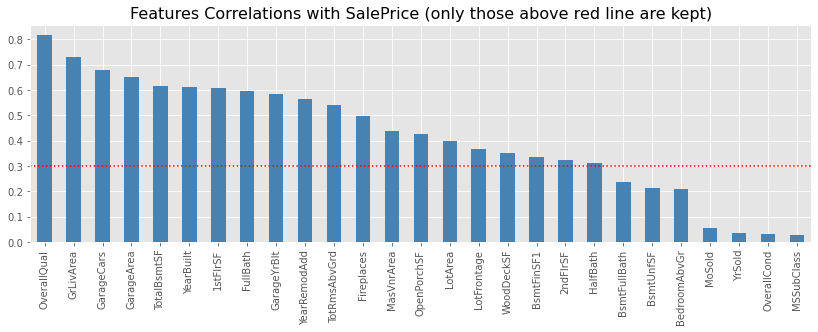

In [106]:
ax = sorted_corrs.drop('SalePrice').plot(kind='bar', color='steelblue',figsize=(14,4))
ax.axhline(corr_thr, c='r', linestyle=':')

plt.title("Features Correlations with SalePrice (only those above red line are kept)", size=16)

plt.show()

In [107]:
# Apply to the entire dataset (train + test)
df_num = df_num.drop(weak_corrs.index, axis=1)
df_num.head().transpose()

Id                       1             2             3             4  \
LotFrontage   1.508653e+01  1.699962e+01  1.548462e+01  1.440323e+01   
LotArea       1.342452e+01  1.369453e+01  1.403413e+01  1.368342e+01   
OverallQual   7.000000e+00  6.000000e+00  7.000000e+00  7.000000e+00   
YearBuilt     3.035191e+51  2.444491e+51  2.987217e+51  1.482547e+51   
YearRemodAdd  2.003000e+03  1.976000e+03  2.002000e+03  1.970000e+03   
MasVnrArea    1.937855e+01  0.000000e+00  1.772107e+01  0.000000e+00   
BsmtFinSF1    1.178559e+02  1.468058e+02  9.157528e+01  5.277637e+01   
TotalBsmtSF   2.968323e+02  4.073024e+02  3.148050e+02  2.682343e+02   
1stFlrSF      5.318379e+00  5.550627e+00  5.362015e+00  5.388291e+00   
2ndFlrSF      1.019541e+03  0.000000e+00  1.034307e+03  8.992006e+02   
GrLivArea     7.234115e+00  6.947211e+00  7.275132e+00  7.237969e+00   
FullBath      2.000000e+00  2.000000e+00  2.000000e+00  1.000000e+00   
HalfBath      1.069352e+00  0.000000e+00  1.069352e+00  0.000000e+00   
TotRmsAbvGrd  2.238463e+00  1.978208e+00  1.978208e+00  2.116352e+00   
Fireplaces    0.000000e+00  9.008155e-01  9.008155e-01  9.008155e-01   
GarageYrBlt   8.440343e+56  6.646187e+56  8.293164e+56  8.076926e+56   
GarageCars    2.000000e+00  2.000000e+00  2.000000e+00  3.000000e+00   
GarageArea    5.480000e+02  4.600000e+02  6.080000e+02  6.420000e+02   
WoodDeckSF    0.000000e+00  5.633920e+01  0.000000e+00  0.000000e+00   
OpenPorchSF   1.200956e+01  0.000000e+00  9.849185e+00  8.921747e+00   

Id                       5  
LotFrontage   1.748033e+01  
LotArea       1.455014e+01  
OverallQual   8.000000e+00  
YearBuilt     2.963497e+51  
YearRemodAdd  2.000000e+03  
MasVnrArea    2.532312e+01  
BsmtFinSF1    1.120403e+02  
TotalBsmtSF   3.762593e+02  
1stFlrSF      5.493032e+00  
2ndFlrSF      1.265168e+03  
GrLivArea     7.470741e+00  
FullBath      2.000000e+00  
HalfBath      1.069352e+00  
TotRmsAbvGrd  2.347900e+00  
Fireplaces    9.008155e-01  
GarageYrBlt   8.220485e+56  
GarageCars    3.000000e+00  
GarageArea    8.360000e+02  
WoodDeckSF    4.235129e+01  
OpenPorchSF   1.418024e+01

#### Features collinearity

Up to now, we observerd correlations between features and the target column "SalePrice". We filtered out lower values since they don't have relevant information.

We will now observe if there are features that we can still remove due to collinearity (high correlation between each other). This is, redundant information. If some features present collinearity, only one of them will be usefull. By removing redundant information, we will decrease the model complexity, which is desired.

In [109]:
good_features = df_num[strong_corrs.index].corr()

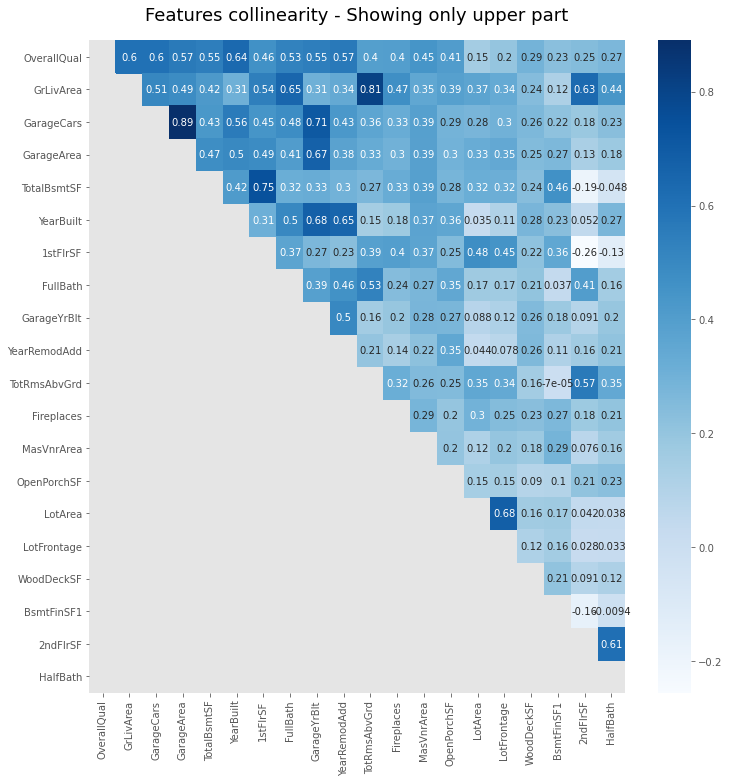

In [111]:
f, ax = plt.subplots(1,1, figsize=(12, 12))

mask = np.tril(np.ones_like(good_features, dtype=np.bool))

sns.heatmap(good_features, cmap='Blues', mask=mask, annot=True)

_ = ax.set_title('Features collinearity - Showing only upper part',
                 pad=20, loc='center', size=18)

Since I am looking collinearity (high correlation between features), I decided that a threshold would be set to highlight which features are redundant for this project.

We will observe how many features are highly correlated with others for different correlation thresholds.
From this analysis, we will make a tradeoff when deciding which threshold is the appropiate to be removed.

In [113]:
corr_thresholds = list(np.arange(0.4,0.7,0.01).round(decimals=2))

print('Based on different thresholds, with how many features is each feature highly correlated?\n')
print('The following table shows the answer for different correlation thresholds:')
df_corr_test = pd.DataFrame(index=good_features.index)

for corr_threshold in corr_thresholds:
    collinear_features = good_features > corr_threshold

    found_corrs = collinear_features.sum()
    findings = found_corrs[found_corrs > 1] - 1
    
    df_corr_test[corr_threshold] = findings

df_corr_test = df_corr_test.fillna(0).astype('int')
df_corr_test

Based on different thresholds, with how many features is each feature highly correlated?

The following table shows the answer for different correlation thresholds:


0.40  0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  ...  \
OverallQual     11    10    10    10    10     9     9     8     8     8  ...   
GrLivArea       10    10    10     9     8     8     8     7     7     6  ...   
GarageCars       9     9     9     8     7     6     6     6     5     5  ...   
GarageArea       8     7     7     7     7     7     7     7     6     4  ...   
TotalBsmtSF      7     7     6     5     4     4     4     3     2     2  ...   
YearBuilt        7     7     6     6     6     6     6     6     6     6  ...   
1stFlrSF         7     7     7     7     7     6     5     4     3     2  ...   
FullBath         8     6     6     6     6     6     5     5     4     4  ...   
GarageYrBlt      5     5     5     5     5     5     5     5     5     5  ...   
YearRemodAdd     5     5     5     4     4     4     3     3     3     3  ...   
TotRmsAbvGrd     3     3     3     3     3     3     3     3     3     3  ...   
Fireplaces       1     1     1     1     1     1     1     0     0     0  ...   
MasVnrArea       1     1     1     1     1     0     0     0     0     0  ...   
OpenPorchSF      1     0     0     0     0     0     0     0     0     0  ...   
LotArea          2     2     2     2     2     2     2     2     1     1  ...   
LotFrontage      2     2     2     2     2     2     1     1     1     1  ...   
WoodDeckSF       0     0     0     0     0     0     0     0     0     0  ...   
BsmtFinSF1       1     1     1     1     1     1     1     0     0     0  ...   
2ndFlrSF         4     3     3     3     3     3     3     3     3     3  ...   
HalfBath         2     2     2     2     1     1     1     1     1     1  ...   

              0.60  0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  
OverallQual      2     1     1     1     0     0     0     0     0     0  
GrLivArea        3     3     3     3     2     2     1     1     1     1  
GarageCars       3     2     2     2     2     2     2     2     2     2  
GarageArea       2     2     2     2     2     2     2     2     1     1  
TotalBsmtSF      1     1     1     1     1     1     1     1     1     1  
YearBuilt        3     3     3     3     2     2     1     1     0     0  
1stFlrSF         1     1     1     1     1     1     1     1     1     1  
FullBath         1     1     1     1     1     1     0     0     0     0  
GarageYrBlt      3     3     3     3     3     3     3     3     1     1  
YearRemodAdd     1     1     1     1     1     1     0     0     0     0  
TotRmsAbvGrd     1     1     1     1     1     1     1     1     1     1  
Fireplaces       0     0     0     0     0     0     0     0     0     0  
MasVnrArea       0     0     0     0     0     0     0     0     0     0  
OpenPorchSF      0     0     0     0     0     0     0     0     0     0  
LotArea          1     1     1     1     1     1     1     1     0     0  
LotFrontage      1     1     1     1     1     1     1     1     0     0  
WoodDeckSF       0     0     0     0     0     0     0     0     0     0  
BsmtFinSF1       0     0     0     0     0     0     0     0     0     0  
2ndFlrSF         2     1     1     1     0     0     0     0     0     0  
HalfBath         1     0     0     0     0     0     0     0     0     0  

[20 rows x 30 columns]

Lets see the table above as a plot:

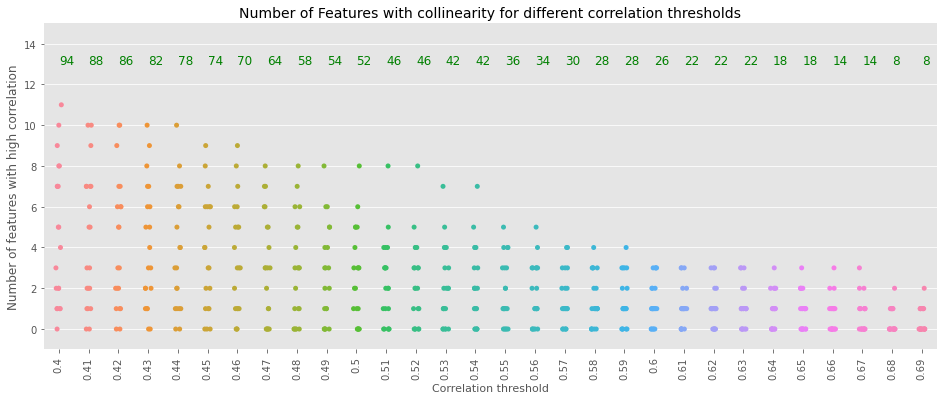

In [120]:
from matplotlib.ticker import FormatStrFormatter

f, ax = plt.subplots(figsize=(16,6))
sns.despine(bottom=True, left=True)
sns.stripplot(data=df_corr_test)

handles, labels = ax.get_legend_handles_labels()
ax.set_title("Number of Features with collinearity for different correlation thresholds", size=14)
ax.set_xlabel("Correlation threshold", size=11)
ax.set_ylabel("Number of features with high correlation", size=12)
ax.set_ylim(-1,15)

for idx, sum_of_feats in enumerate(df_corr_test.sum()):
    ax.text(idx, 13, s=str(sum_of_feats), c='green', size=12)

_ = plt.xticks(rotation=90)

We can observe in the plot above that the features quantity is decreasing when we increase the threshold, which is as espected. I will use a threshold of **0.56** to test a significant reduction and **0.46** to check whether the model perfomance is significantly better or not.

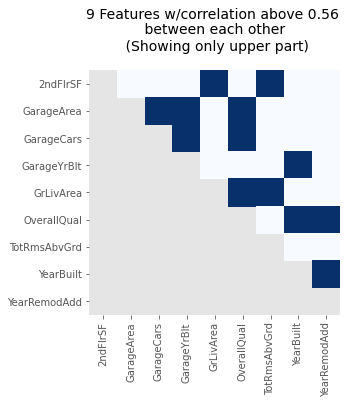

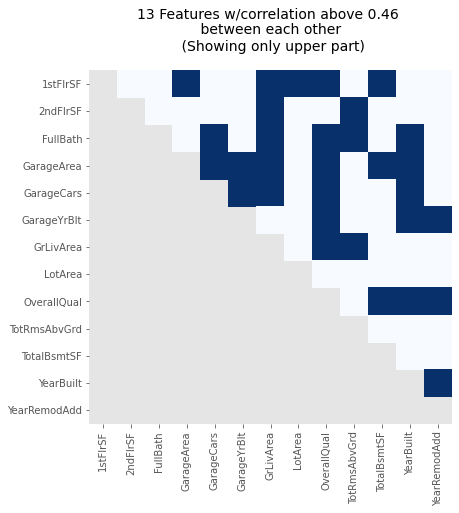

In [126]:
corr_thresholds = [0.56, 0.46]

for corr_threshold in corr_thresholds:
    collinear_features = df_num.corr() > corr_threshold
    found_corrs = collinear_features.sum() - 1 # minus itself
    
    # Exclude the correlation matrix's diagonal
    cols = sorted(list(found_corrs[found_corrs > 1].index))
    df_to_plot = collinear_features.loc[cols, cols]

    # Generate a mask for the lower triangle for plotting
    mask = np.tril(np.ones_like(df_to_plot, dtype=np.bool))

    plot_size = len(df_to_plot.columns)
    f, ax = plt.subplots(figsize=(plot_size*0.5, plot_size*0.5))

    sns.heatmap(df_to_plot,  mask=mask, cmap='Blues', cbar=False)
    _ = ax.set_title("{} Features w/correlation above {} \n between each other \n (Showing only upper part)"
        .format(plot_size, corr_threshold), pad=20, loc='center', size=14)

Based on the collinearity with the thresholds listed above, we can tell the pairs of columns that are strongly correlated with blue color.

##### Finally, can we drop features that are redundant, i.e. have collinearity?

In [127]:
df_corr = df_num.corr()[collinear_features].loc[cols,cols]
df_corr = df_corr.replace(1,np.nan)
df_corr

1stFlrSF  2ndFlrSF  FullBath  GarageArea  GarageCars  \
1stFlrSF           NaN       NaN       NaN    0.486408         NaN   
2ndFlrSF           NaN       NaN       NaN         NaN         NaN   
FullBath           NaN       NaN       NaN         NaN    0.478876   
GarageArea    0.486408       NaN       NaN         NaN    0.889890   
GarageCars         NaN       NaN  0.478876    0.889890         NaN   
GarageYrBlt        NaN       NaN       NaN    0.674752    0.710738   
GrLivArea     0.541699  0.634786  0.652273    0.486977    0.509286   
LotArea       0.476732       NaN       NaN         NaN         NaN   
OverallQual   0.463671       NaN  0.528483    0.565179    0.600743   
TotRmsAbvGrd       NaN  0.567661  0.528326         NaN         NaN   
TotalBsmtSF   0.745345       NaN       NaN    0.474232         NaN   
YearBuilt          NaN       NaN  0.503857    0.497904    0.559643   
YearRemodAdd       NaN       NaN       NaN         NaN         NaN   

              GarageYrBlt  GrLivArea   LotArea  OverallQual  TotRmsAbvGrd  \
1stFlrSF              NaN   0.541699  0.476732     0.463671           NaN   
2ndFlrSF              NaN   0.634786       NaN          NaN      0.567661   
FullBath              NaN   0.652273       NaN     0.528483      0.528326   
GarageArea       0.674752   0.486977       NaN     0.565179           NaN   
GarageCars       0.710738   0.509286       NaN     0.600743           NaN   
GarageYrBlt           NaN        NaN       NaN     0.546143           NaN   
GrLivArea             NaN        NaN       NaN     0.599234      0.810129   
LotArea               NaN        NaN       NaN          NaN           NaN   
OverallQual      0.546143   0.599234       NaN          NaN           NaN   
TotRmsAbvGrd          NaN   0.810129       NaN          NaN           NaN   
TotalBsmtSF           NaN        NaN       NaN     0.547045           NaN   
YearBuilt        0.676879        NaN       NaN     0.635395           NaN   
YearRemodAdd     0.501817        NaN       NaN     0.571532           NaN   

              TotalBsmtSF  YearBuilt  YearRemodAdd  
1stFlrSF         0.745345        NaN           NaN  
2ndFlrSF              NaN        NaN           NaN  
FullBath              NaN   0.503857           NaN  
GarageArea       0.474232   0.497904           NaN  
GarageCars            NaN   0.559643           NaN  
GarageYrBlt           NaN   0.676879      0.501817  
GrLivArea             NaN        NaN           NaN  
LotArea               NaN        NaN           NaN  
OverallQual      0.547045   0.635395      0.571532  
TotRmsAbvGrd          NaN        NaN           NaN  
TotalBsmtSF           NaN        NaN           NaN  
YearBuilt             NaN        NaN      0.654752  
YearRemodAdd          NaN   0.654752           NaN

In [128]:
df_corr.max().sort_values(ascending=False)

GarageCars      0.889890
GarageArea      0.889890
TotRmsAbvGrd    0.810129
GrLivArea       0.810129
TotalBsmtSF     0.745345
1stFlrSF        0.745345
GarageYrBlt     0.710738
YearBuilt       0.676879
YearRemodAdd    0.654752
FullBath        0.652273
OverallQual     0.635395
2ndFlrSF        0.634786
LotArea         0.476732
dtype: float64

We will keep the features as they are, since there are only few features that have high collinearity. By removing these features, the improvement regarding model complexity reduction will not be significant.

In case we want to test the model effectiveness with a higher correlation threshold of 0.56, then this process should be evaluated again. The final numerical features that we will use to train the model are listed below:

In [130]:
df_num = df_num.loc[:,df_corr.columns]
df_num.columns

Index(['1stFlrSF', '2ndFlrSF', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'LotArea', 'OverallQual', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

#### Scaling features

We came from 38 numerical feature to a reduced set of useful numerical features. In this step, each of them will be scaled in a range from 0 to 1. Feature scaling helps ensure that some columns aren't weighted more than others when helping the model make predictions.

In [131]:
def apply_scaling(df):
    """
    Feature Scaling from 0 to 1
    """
    # Feature Scaling
    max_val = df.max()
    min_val = df.min()
    df = (df - min_val)/(max_val - min_val)
    return df

In [132]:
# Validation
apply_scaling(df_num).describe().transpose()

count      mean       std  min       25%       50%       75%  \
1stFlrSF      2919.0  0.460560  0.119795  0.0  0.376709  0.455781  0.547343   
2ndFlrSF      2919.0  0.158511  0.203064  0.0  0.000000  0.000000  0.329907   
FullBath      2919.0  0.392001  0.138242  0.0  0.250000  0.500000  0.500000   
GarageArea    2919.0  0.317683  0.144849  0.0  0.215054  0.322581  0.387097   
GarageCars    2919.0  0.353203  0.152439  0.0  0.200000  0.400000  0.400000   
GarageYrBlt   2919.0  0.140841  0.047997  0.0  0.120389  0.143995  0.178084   
GrLivArea     2919.0  0.515107  0.114960  0.0  0.432275  0.520336  0.586959   
LotArea       2919.0  0.330230  0.093375  0.0  0.296204  0.339231  0.377005   
OverallQual   2919.0  0.565452  0.156661  0.0  0.444444  0.555556  0.666667   
TotRmsAbvGrd  2919.0  0.527376  0.123688  0.0  0.410649  0.502629  0.582499   
TotalBsmtSF   2919.0  0.235058  0.082565  0.0  0.189644  0.227063  0.284092   
YearBuilt     2919.0  0.636490  0.253459  0.0  0.461403  0.621971  0.898183   
YearRemodAdd  2919.0  0.571075  0.348239  0.0  0.250000  0.716667  0.900000   

              max  
1stFlrSF      1.0  
2ndFlrSF      1.0  
FullBath      1.0  
GarageArea    1.0  
GarageCars    1.0  
GarageYrBlt   1.0  
GrLivArea     1.0  
LotArea       1.0  
OverallQual   1.0  
TotRmsAbvGrd  1.0  
TotalBsmtSF   1.0  
YearBuilt     1.0  
YearRemodAdd  1.0

In [133]:
df_num

1stFlrSF     2ndFlrSF  FullBath  GarageArea  GarageCars   GarageYrBlt  \
Id                                                                            
1     5.318379  1019.540835         2       548.0         2.0  8.440343e+56   
2     5.550627     0.000000         2       460.0         2.0  6.646187e+56   
3     5.362015  1034.306520         2       608.0         2.0  8.293164e+56   
4     5.388291   899.200621         1       642.0         3.0  8.076926e+56   
5     5.493032  1265.167836         2       836.0         3.0  8.220485e+56   
...        ...          ...       ...         ...         ...           ...   
2915  5.041055   643.029827         1         0.0         0.0  0.000000e+00   
2916  5.041055   643.029827         1       286.0         1.0  6.299647e+56   
2917  5.532572     0.000000         1       576.0         2.0  5.759674e+56   
2918  5.393898     0.000000         1         0.0         0.0  0.000000e+00   
2919  5.409788  1204.543149         2       650.0         3.0  7.728305e+56   

      GrLivArea    LotArea  OverallQual  TotRmsAbvGrd  TotalBsmtSF  \
Id                                                                   
1      7.234115  13.424521            7      2.238463   296.832312   
2      6.947211  13.694528            6      1.978208   407.302390   
3      7.275132  14.034134            7      1.978208   314.805039   
4      7.237969  13.683422            7      2.116352   268.234274   
5      7.470741  14.550143            8      2.347900   376.259341   
...         ...        ...          ...           ...          ...   
2915   6.810355  10.503898            4      1.819119   205.682488   
2916   6.810355  10.463056            4      1.978208   205.682488   
2917   6.918304  15.304041            5      2.116352   397.281490   
2918   6.698196  13.873787            5      1.978208   312.571548   
2919   7.381816  13.700503            7      2.347900   335.847425   

         YearBuilt  YearRemodAdd  
Id                                
1     3.035191e+51          2003  
2     2.444491e+51          1976  
3     2.987217e+51          2002  
4     1.482547e+51          1970  
5     2.963497e+51          2000  
...            ...           ...  
2915  2.328765e+51          1970  
2916  2.328765e+51          1970  
2917  2.147229e+51          1996  
2918  2.779998e+51          1992  
2919  2.802338e+51          1994  

[2919 rows x 13 columns]

## Saving the work done
That's all for now. I will split the job from this point forwards by saving the numerical features in one file. This file will be used as input for later work. The same process is applied to the test dataset.

In [139]:
train_df_num = pd.concat((df_num[:train_shape[0]], df_train['SalePrice']), axis=1)
train_df_num

1stFlrSF     2ndFlrSF  FullBath  GarageArea  GarageCars   GarageYrBlt  \
Id                                                                            
1     5.318379  1019.540835         2       548.0         2.0  8.440343e+56   
2     5.550627     0.000000         2       460.0         2.0  6.646187e+56   
3     5.362015  1034.306520         2       608.0         2.0  8.293164e+56   
4     5.388291   899.200621         1       642.0         3.0  8.076926e+56   
5     5.493032  1265.167836         2       836.0         3.0  8.220485e+56   
...        ...          ...       ...         ...         ...           ...   
1456  5.383260   823.310159         2       460.0         2.0  8.148407e+56   
1457  5.838137     0.000000         2       500.0         2.0  6.765642e+56   
1458  5.514904  1387.914773         2       252.0         1.0  4.851803e+56   
1459  5.457132     0.000000         1       240.0         1.0  5.263572e+56   
1460  5.547815     0.000000         1       276.0         1.0  6.023956e+56   

      GrLivArea    LotArea  OverallQual  TotRmsAbvGrd  TotalBsmtSF  \
Id                                                                   
1      7.234115  13.424521            7      2.238463   296.832312   
2      6.947211  13.694528            6      1.978208   407.302390   
3      7.275132  14.034134            7      1.978208   314.805039   
4      7.237969  13.683422            7      2.116352   268.234274   
5      7.470741  14.550143            8      2.347900   376.259341   
...         ...        ...          ...           ...          ...   
1456   7.198698  13.287740            6      2.116352   323.980270   
1457   7.415593  14.376784            6      2.116352   479.523980   
1458   7.529679  13.567456            7      2.347900   378.132762   
1459   6.798143  13.720310            5      1.819119   358.217353   
1460   6.942706  13.768026            5      1.978208   405.723933   

         YearBuilt  YearRemodAdd  SalePrice  
Id                                           
1     3.035191e+51          2003  12.247699  
2     2.444491e+51          1976  12.109016  
3     2.987217e+51          2002  12.317171  
4     1.482547e+51          1970  11.849405  
5     2.963497e+51          2000  12.429220  
...            ...           ...        ...  
1456  2.939955e+51          2000  12.072547  
1457  2.484249e+51          1988  12.254868  
1458  1.838275e+51          2006  12.493133  
1459  1.979023e+51          1996  11.864469  
1460  2.236271e+51          1965  11.901590  

[1460 rows x 14 columns]

In [140]:
test_df_num = df_num[train_shape[0]:].copy()
test_df_num

1stFlrSF     2ndFlrSF  FullBath  GarageArea  GarageCars   GarageYrBlt  \
Id                                                                            
1461  5.346045     0.000000         1       730.0         1.0  5.811639e+56   
1462  5.581083     0.000000         1       312.0         1.0  5.657055e+56   
1463  5.367240   831.868365         2       482.0         2.0  8.006037e+56   
1464  5.365938   803.758518         2       470.0         2.0  8.076926e+56   
1465  5.558977     0.000000         2       506.0         2.0  7.660306e+56   
...        ...          ...       ...         ...         ...           ...   
2915  5.041055   643.029827         1         0.0         0.0  0.000000e+00   
2916  5.041055   643.029827         1       286.0         1.0  6.299647e+56   
2917  5.532572     0.000000         1       576.0         2.0  5.759674e+56   
2918  5.393898     0.000000         1         0.0         0.0  0.000000e+00   
2919  5.409788  1204.543149         2       650.0         3.0  7.728305e+56   

      GrLivArea    LotArea  OverallQual  TotRmsAbvGrd  TotalBsmtSF  \
Id                                                                   
1461   6.623018  14.104341            5      1.819119   304.163006   
1462   6.996107  14.551221            6      1.978208   424.835016   
1463   7.188328  14.482936            5      1.978208   317.034905   
1464   7.173732  13.776812            6      2.116352   316.477777   
1465   6.960600  12.345545            8      1.819119   412.029378   
...         ...        ...          ...           ...          ...   
2915   6.810355  10.503898            4      1.819119   205.682488   
2916   6.810355  10.463056            4      1.978208   205.682488   
2917   6.918304  15.304041            5      2.116352   397.281490   
2918   6.698196  13.873787            5      1.978208   312.571548   
2919   7.381816  13.700503            7      2.347900   335.847425   

         YearBuilt  YearRemodAdd  
Id                                
1461  2.164767e+51          1961  
1462  2.112552e+51          1958  
1463  2.893394e+51          1998  
1464  2.916587e+51          1998  
1465  2.779998e+51          1992  
...            ...           ...  
2915  2.328765e+51          1970  
2916  2.328765e+51          1970  
2917  2.147229e+51          1996  
2918  2.779998e+51          1992  
2919  2.802338e+51          1994  

[1459 rows x 13 columns]

In [143]:
#save datasets
train_df_num.to_csv("out/house_prices_num_feats_train.csv")
test_df_num.to_csv("out/house_prices_num_feats_test.csv")